In [33]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing

In [49]:
def generate(X):
    f_x = 1 / ((X ** 2) - (3 * X) + 2)
    f_x = np.clip(f_x, -100, 100)
    noise = np.random.normal(size=X.shape)
    return f_x + noise

In [50]:
x_k = 3 * np.arange(1001) / 1000
y_k = generate(x_k)

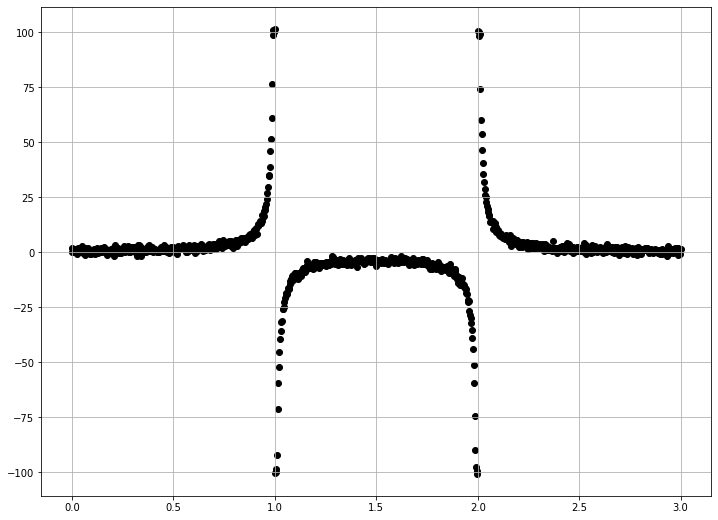

In [51]:
plt.figure(figsize=(12,9))
plt.scatter(x_k, y_k, color='black')
plt.grid()

In [52]:
def f(X, a, b, c, d):
    return (a * X + b) / (X**2 + c * X + d)

def least_squares_minimization(params):
    global x_k, y_k  
    a, b, c, d = params
    return np.sum((f(x_k, a, b, c, d) - y_k)**2)

def least_squares_lm(params):
    global x_k, y_k  
    a, b, c, d = params
    return f(x_k, a, b, c, d) - y_k

In [53]:
nm = minimize(least_squares_minimization, [0,0,0,0], method="Nelder-Mead", tol=0.001)
lm = least_squares(least_squares_lm, [1, 1, 1, 1], method="lm", xtol=0.001, ftol=0.001)
de = differential_evolution(least_squares_minimization, [(0, 1), (0, 1), (0, 1), (0, 1)], x0=[1, 1, 1, 1], tol=0.001, maxiter=1000)
da = dual_annealing(least_squares_minimization, [(0, 1), (0, 1), (0, 1), (0, 1)], x0=[1, 1, 1, 1], maxiter=1000)

C:\Users\rbezaev\AppData\Local\Temp/ipykernel_22444/4090107763.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (a * X + b) / (X**2 + c * X + d)
C:\Users\rbezaev\AppData\Local\Temp/ipykernel_22444/4090107763.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return (a * X + b) / (X**2 + c * X + d)
c:\users\rbezaev\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [54]:
image_no = 0

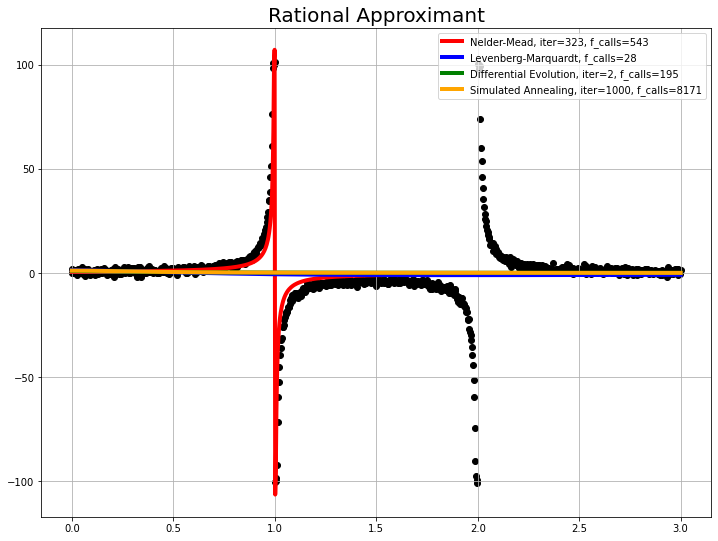

In [55]:
plt.figure(figsize=(12,9))
plt.title("Rational Approximant", fontdict={"size":20})
plt.scatter(x_k, y_k, color='black')
plt.plot(x_k, (nm.x[0] * x_k + nm.x[1]) / (x_k**2 + nm.x[2] * x_k + nm.x[3]), color='red', label=f"Nelder-Mead, iter={nm.nit}, f_calls={nm.nfev}", linewidth=4)
plt.plot(x_k, (lm.x[0] * x_k + lm.x[1]) / (x_k**2 + lm.x[2] * x_k + lm.x[3]), color='blue', label=f"Levenberg-Marquardt, f_calls={lm.nfev}", linewidth=4)
plt.plot(x_k, (de.x[0] * x_k + de.x[1]) / (x_k**2 + de.x[2] * x_k + de.x[3]), color='green', label=f"Differential Evolution, iter={de.nit}, f_calls={de.nfev}", linewidth=4)
plt.plot(x_k, (da.x[0] * x_k + da.x[1]) / (x_k**2 + da.x[2] * x_k + da.x[3]), color='orange', label=f"Simulated Annealing, iter={da.nit}, f_calls={da.nfev}", linewidth=4)
plt.legend()
plt.grid()

plt.savefig( ("%05d" % image_no) + '.png')
image_no += 1

In [56]:
import math


# calulate length between two points
def length(n1, n2):
    return math.sqrt((n1[0] - n2[0])**2 + (n1[1] - n2[1])**2)


# calculate total length to traverse all points
def total_length(arr,n):
    l = length(arr[0],arr[n-1])
    for i in range(n-1):
        l += length(arr[i],arr[i+1])
    
    return l

In [69]:
# two_opt optimization for simulated annealing, using a random probabilty function to do selection
def two_opt_optimization(sol_arr, t, n, min_l):
    # picking two pair of consecutive integers, making sure they are not same
    ai = np.random.randint(0, n)
    bi = (ai+1)%n
    ci = np.random.randint(0, n)
    di = (ci+1)%n
    ai_,bi_,ci_,di_ = ai,bi,ci,di

    if ai != ci and bi != ci:
        a = sol_arr[ai]
        b = sol_arr[bi]
        c = sol_arr[ci]
        d = sol_arr[di]

        # old lengths
        ab = length(a,b)
        cd = length(c,d)

        # new lengths, if accepted by our probability function
        ac = length(a,c)
        bd = length(b,d)

        diff = (ab + cd) - (ac + bd)

        p = 0
        # for negative diff-> we'll use boltzman probabilty distribution equation-> P(E)=exp(-E/kT)
        if diff < 0:
            # k is considered to be 1
            p = math.exp(diff/t)

        # we'll sometimes skip the good solution
        elif diff > 0.05 :
            p = 1

        
        if np.random.random() < p:
            
            new_arr = list(range(n))
            new_arr[0] = sol_arr[ai]
            i = 1

            while bi != ci:

                new_arr[i] = sol_arr[ci]
                i += 1
                ci = (ci-1)%n

            new_arr[i] = sol_arr[bi]
            i += 1

            while ai != di:
                new_arr[i] = sol_arr[di]
                i += 1
                di = (di+1)%n

            return new_arr

    return sol_arr


# Simmulated Annealing algorithm----------------------------------------------	

def sa_algorithm(input_data):

    #length of input_data
    n = len(input_data)

    #creating a base solution
    sol_arr = input_data

    global image_no
    image_no = 1
    plt.clf();
    #plt.title('Travelling Salesman Problem\n')
    #plt.axes([-10,1010,-10,1010])
    #plt.ylim(-100,40)
    #plt.xlim(-100,40)
    #plt.axis('off')

    #plotting base solution
    for i in range(n):
        plt.scatter(sol_arr[i][0],sol_arr[i][1],color='g',s=50)
        
    
    plt.savefig( ("%05d" % image_no) + '.png')
    image_no += 1


    for i in range(n):
        plt.plot( [sol_arr[i][0],sol_arr[(i+1)%n][0]], [sol_arr[i][1],sol_arr[(i+1)%n][1]], color='b')
    
    
    plt.savefig( ("%05d" % image_no) + '.png')
    image_no += 1
    
    plt.show()
    plt.clf()


    #initial temperature
    t = 100

    #current length
    min_l = total_length(sol_arr,n)
    print("Length on the first iteration", min_l)
    
    i=0
    best_arr=[]
    
    
    while t>0.1:

        i += 1

        #two_opt method- for optimization
        sol_arr = two_opt_optimization(sol_arr, t, n, min_l)

        #after 20 steps restart the process until the temperature is less than 0.1
        if i >= 20 :

            i=0
            current_l = total_length(sol_arr,n)

            t -=0.1

            if current_l < min_l:
                min_l = current_l
                best_arr = sol_arr[:]
    
    
    for i in range(n):
        plt.scatter(sol_arr[i][0],sol_arr[i][1],color='g',s=50)
    

    for i in range(n):
        plt.plot( [sol_arr[i][0],sol_arr[(i+1)%n][0]], [sol_arr[i][1],sol_arr[(i+1)%n][1]], color='b')
    
    
    plt.savefig( ("%05d" % image_no) + '.png')
    image_no += 1

    plt.show()
    plt.clf()
    
    return best_arr

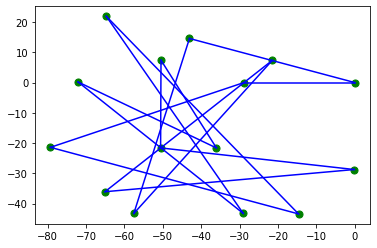

Length on the first iteration 818.0261064149839


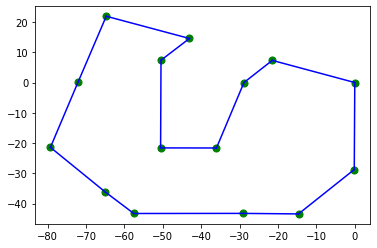

minimum length using simulated annealing:
301.3583384037519


<Figure size 432x288 with 0 Axes>

In [70]:
data = []
s = "cities.txt"

with open(s) as f:
    for line in f:
        numbers_str = line.split()
        x = float(numbers_str[0])
        y = float(numbers_str[1])
        data.append((x,y))


n = len(data)
final_arr = sa_algorithm(data)
final_l = total_length(final_arr,n)

print("minimum length using simulated annealing:")
print(final_l)